### Rice P&A Journal Club
# ["Detection of nanoflare-heated plasma in the solar corona by the FOXSI-2 sounding rocket"](https://www.nature.com/articles/s41550-017-0269-z)
## Shin-nosuke Ishikawa, Lindsay Glesener, Säm Krucker, Steven Christe, Juan Camilo Buitrago-Casas, Noriyuki Narukage and Juliana Vievering
### Will Barnes, 13 April 2018

In [1]:
import subprocess
import os
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.animation
import astropy.units as u
import sunpy.map
import synthesizAR

%matplotlib inline

# Outline
* The Coronal Heating Problem
* Nanoflares: A (Possible) Solution
* FOXSI
* Observations of Hot Plasma

# The Coronal Heating Problem

* Intro coronal heating
* Nice picture of EUV sun versus visual sun
* Movie of flare
* Don't care about flares
* Care about non-flaring ARs

# Nanoflares: A Possible Solution

* Brief explanation of nanoflares
* A few cartoons
* Explain (briefly) why these are so hard to detect

# Focusing Optics X-ray Solar Imager (FOXSI)

* Discuss the instrument
  * sounding rocket
  * Paper presents results from second flight 
  * FOXSI-3 will fly again in August of this year
* Advantages of HXR versus EUV

<p float="center">
<img src="img/foxsi-1-logo.png" width="300">
<img src="img/foxsi-2-logo.png" width="300">
<img src="img/foxsi-3-logo.png" width="300">
</p>

# Observations of Hot Plasma

* Show figures from paper
* Talk about the results

# Aside: The Differential Emission Measure ($\mathrm{DEM}(T)$)

* Illustration of loop
* EBTEL example movie showing heating input, temperature, density, and DEM
  * Constant heating
  * single pulse

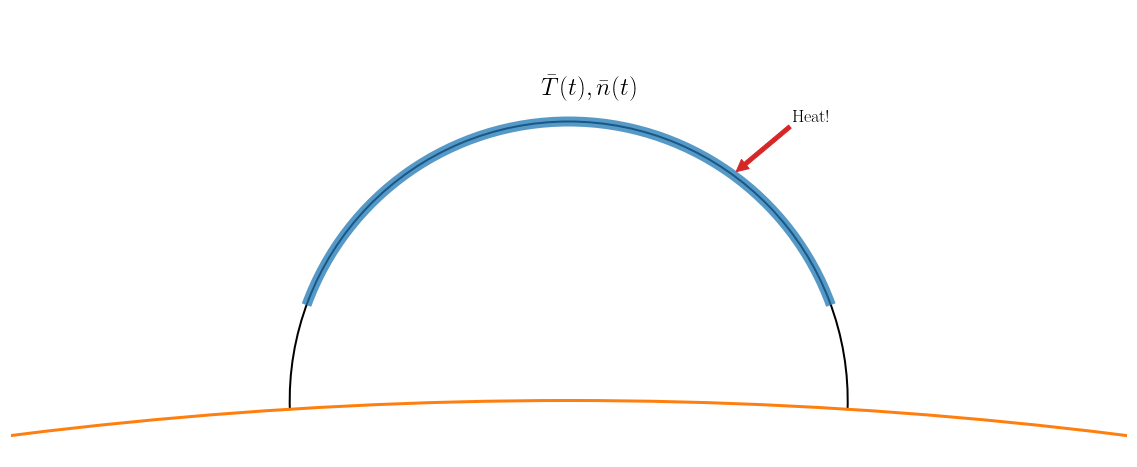

In [183]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
arc = matplotlib.patches.Arc((0,0),1,1, theta1=-2, theta2=182, lw=2)
arc2 = matplotlib.patches.Arc((0,0),1,1, theta1=20, theta2=160, lw=10, color='C0',alpha=0.75)
arc3 = matplotlib.patches.Arc((0,-8),16,16,theta1=0,theta2=180,lw=3,color='C1')
ax.add_patch(arc)
ax.add_patch(arc2)
ax.add_patch(arc3)
ax.set_xlim(-1,1)
ax.set_ylim(-0.1,0.7)
ax.set_aspect('equal')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params('both',which='both',bottom='off',left='off',labelbottom='off',labelleft='off')
ax.annotate('Heat!', xy=(0.3, 0.41), xytext=(0.4, 0.5),fontsize=18,
            arrowprops=dict(facecolor='C3', edgecolor='C3', shrink=1.),);
ax.text(-0.05,0.55, r'$\bar{T}(t),\bar{n}(t)$',fontsize=25);

Run a few EBTEL simulations and compute the EM (as a function of T). Animate it too

In [127]:
class EM_Binner(object):

    def __init__(self,loop_length,time=None,temp=None,density=None,read_abundances=False,dVolume=None,**kwargs):
        self.loop_length = loop_length
        self.dVolume = dVolume
        #set up logger
        #Get abundances
        #set data
        if time is not None and temp is not None and density is not None:
            self.set_data(time,temp,density)

    def set_data(self,time,temp,density):
        """Add parameters as class attributes"""
        self.time = time
        self.temp = temp
        self.density = density

    def make_T_bins(self,logT_a=4.0,logT_b=8.5,delta_logT=0.01):
        """Build temperature bins in log_10 for creating EM distribution"""

        self.delta_logT = delta_logT
        self.T_em = np.logspace(logT_a,logT_b,int((logT_b - logT_a)/self.delta_logT))
        #Add right edge for histogram bins
        self.T_em_histo_bins = np.append(self.T_em,self.T_em[-1]*10.**self.delta_logT)

    def _emission_measure_calc(self,n):
        """Calculate either column or volumetric emission measure distribution"""

        if self.dVolume is not None:
            return self.dVolume*n**2
        else:
            return self.loop_length*n**2

    def _differential_emission_measure_calc(self,n,tmin,tmax):
        """Calculate differential emission measure distribution"""

        em = self._emission_measure_calc(n)
        #EBTEL method for calculating coronal DEM
        tmax = np.log10(tmax)
        tmin = np.log10(tmin)
        jmax = (tmax - 4.0)*100.0
        jmin = (tmin - 4.0)*100.0
        delta_t = 1.0e+4*(10.0**((jmax + 0.5)/100.0) - 10.0**((jmin - 0.5)/100.0));
        return em/delta_t

    def _coronal_limits(self,T):
        """Find limits of corona in log temperature space."""

        #Use EBTEL method for calculating coronal temperature bounds
        #logT_C_a = np.log10(2.0/3.0*T)
        T_C_a = 8.0/9.0*T
        T_C_b = 10.0/9.0*T
        return T_C_a,T_C_b

    def build_em_dist(self,build_mat=False):
        """Create EM distribution from temperature arrays. Build for both T and T_eff"""

        try:
            self.T_em
        except AttributeError:
            self.make_T_bins()

        #allocate space for DEM, EM matrices
        if build_mat:
            self.em_mat = np.zeros([len(self.time),len(self.T_em)])
            self.dem_mat = np.zeros([len(self.time),len(self.T_em)])

        #Flattened EM and temp lists for easily building histograms
        self.em_flat = []
        self.T_em_flat = []

        #Calculate time weights
        w_tau = np.gradient(self.time)/np.sum(np.gradient(self.time))

        #Loop over time
        for i in range(len(self.time)):
            #calculate coronal temperature bounds at time i
            Ta,Tb = self._coronal_limits(self.temp[i])
            #find coronal indices in logT
            iC = np.where((self.T_em >= Ta) & (self.T_em <= Tb))
            if len(iC) > 0:
                if build_mat:
                    #add entries to dem,em matrices
                    self.dem_mat[i,iC[0]] = self._differential_emission_measure_calc(self.density[i],Ta,Tb)
                    self.em_mat[i,iC[0]] = self._emission_measure_calc(self.density[i])
                #append coronal temperatures to temperature list
                self.T_em_flat.append(self.T_em[iC[0]])
                #append emission measure weighted by timestep to emission measure list
                self.em_flat.append(len(iC[0])*[w_tau[i]*self._emission_measure_calc(self.density[i])])

        #cast as numpy arrays for convenience
        #self.T_em_flat = np.array(self.T_em_flat)
        #self.em_flat = np.array(self.em_flat)

In [147]:
ih = synthesizAR.util.InputHandler('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['adaptive_solver_error'] = 1e-6
base_config['adaptive_solver_safety'] = 0.5
base_config['tau']=1.
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 3e-3
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0
base_config['surface_gravity'] = 1.
base_config['loop_length'] = 4e9
base_config['output_filename'] = 'ebtel_run'

In [148]:
config_steady = base_config.copy()
config_steady['heating']['events'] = []
synthesizAR.util.OutputHandler(config_steady['output_filename']+'.xml',config_steady).print_to_xml()
subprocess.run(['/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run', '-c', config_steady['output_filename']+'.xml']);
results = np.loadtxt(config_steady['output_filename'])

In [139]:
emb = EM_Binner(base_config['loop_length'],time=results[:,0],temp=results[:,1],density=results[:,3])
emb.build_em_dist(build_mat=True)

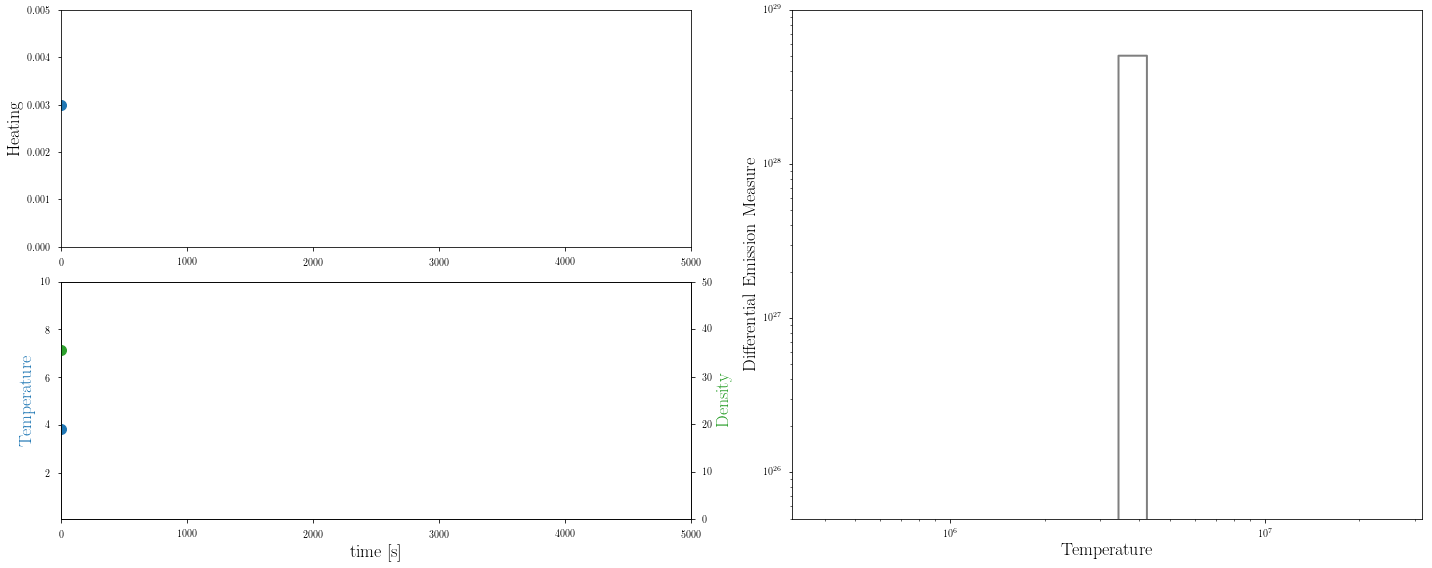

In [140]:
fig = plt.figure(figsize=(20,8))
ax1 = plt.subplot2grid((2, 2), (0, 0),colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0),colspan=1)
ax2_5 = ax2.twinx()
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
line1, = ax1.plot([],[],color='C0')
line2, = ax1.plot([],[], marker='o',markersize=10, color='C0')
line3, = ax2.plot([],[],color='C0', label=r'$T$')
line4, = ax2.plot([],[],marker='o',markersize=10, color='C0')
line5, = ax2_5.plot([],[],color='C2', label=r'$n$')
line6, = ax2_5.plot([],[], marker='o',markersize=10, color='C2')
line7, = ax3.plot([],[],color='k',alpha=0.5)
line8, = ax3.step([1,2],[3,4],where='post',color='C0',)
# Limits and scales
ax1.set_xlim(0,base_config['total_time'])
ax1.set_ylim(0,5e-3)
ax2.set_xlim(0,base_config['total_time'])
ax2.set_ylim(0.1,10)
ax2_5.set_ylim(0.1,50)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlim(10.**(5.5),10**(7.5))
ax3.set_ylim(5e25,1e29)
# Labels and legends
ax1.set_ylabel(r'Heating')
ax2.set_ylabel(r'Temperature')
ax2.yaxis.label.set_color('C0')
ax2.set_xlabel(r'time [s]')
ax2_5.set_ylabel(r'Density')
ax2_5.yaxis.label.set_color('C2')
ax3.set_ylabel(r'Differential Emission Measure')
ax3.set_xlabel(r'Temperature')
plt.tight_layout()

def animate(i):
    line1.set_data(results[:(i+1),0],results[:(i+1),-1])
    line2.set_data(results[i,0], results[i,-1],)
    line3.set_data(results[:(i+1),0],results[:(i+1),1]/1e6)
    line4.set_data(results[i,0], results[i,1]/1e+6,)
    line5.set_data(results[:(i+1),0], results[:(i+1),3]/1e8,)
    line6.set_data(results[i,0], results[i,3]/1e8,)
    line7.set_data(emb.T_em,emb.em_mat[i,:])
    hist,bins = np.histogram(
        [em for em_list in emb.T_em_flat[:(i+1)] for em in em_list],
        weights=[em for em_list in emb.em_flat[:(i+1)] for em in em_list],
        bins=emb.T_em_histo_bins)
    line8.set_data(bins[:-1],hist)
    return [line1,line2,line3,line4,line5,line6,line7,line8,]
    
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=results.shape[0], interval=20, repeat=True,blit=True,)

In [141]:
HTML(anim.to_html5_video())

In [149]:
config_dynamic = base_config.copy()
config_dynamic['heating']['events'] = [
    {'event': {'magnitude': config_steady['heating']['background'] * base_config['total_time'] * 2. / 200.,
               'rise_start': 0., 'rise_end': 100., 'decay_start': 100., 'decay_end': 200.}}
]
config_dynamic['heating']['background'] = 1e-6
synthesizAR.util.OutputHandler(config_dynamic['output_filename']+'.xml',config_dynamic).print_to_xml()
subprocess.run(['/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run', '-c', config_dynamic['output_filename']+'.xml']);
results = np.loadtxt(config_dynamic['output_filename'])

In [150]:
emb = EM_Binner(base_config['loop_length'],time=results[:,0],temp=results[:,1],density=results[:,3])
emb.build_em_dist(build_mat=True)

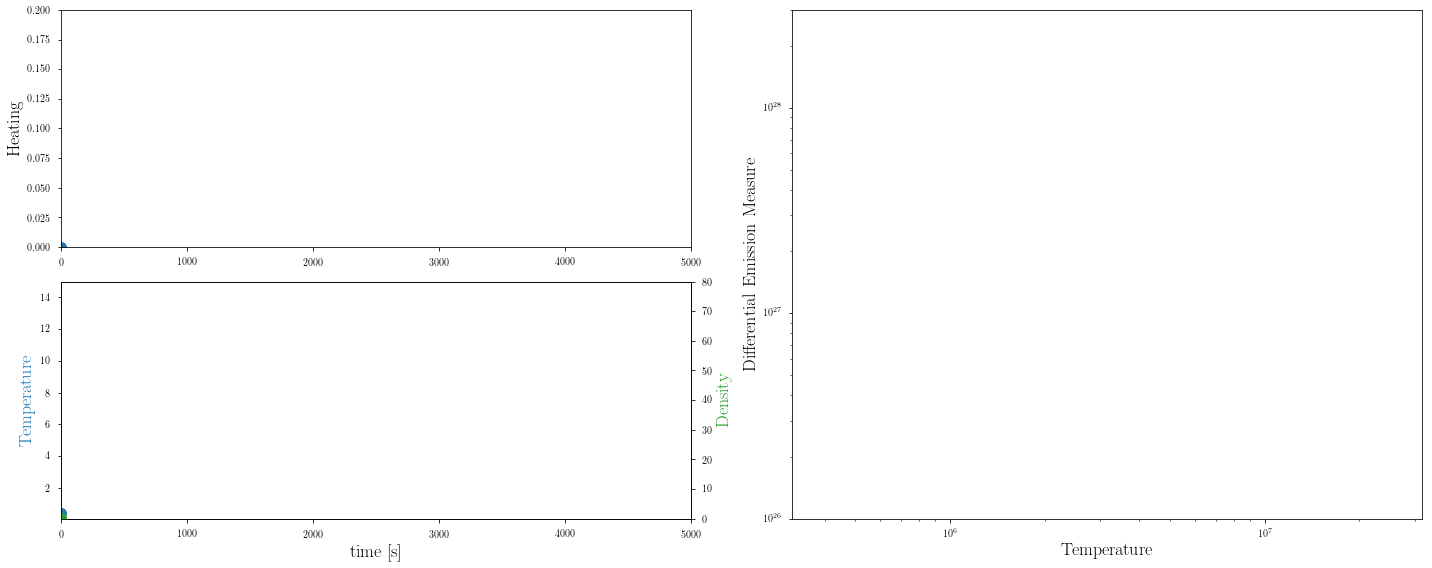

In [151]:
fig = plt.figure(figsize=(20,8))
ax1 = plt.subplot2grid((2, 2), (0, 0),colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0),colspan=1)
ax2_5 = ax2.twinx()
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
line1, = ax1.plot([],[],color='C0')
line2, = ax1.plot([],[], marker='o',markersize=10, color='C0')
line3, = ax2.plot([],[],color='C0')
line4, = ax2.plot([],[],marker='o',markersize=10, color='C0')
line5, = ax2_5.plot([],[],color='C2')
line6, = ax2_5.plot([],[], marker='o',markersize=10, color='C2')
line7, = ax3.step([1,2],[3,4],where='post',color='k',alpha=0.5)
line8, = ax3.step([1,2],[3,4],where='post',color='C0',)
# Limits and scales
ax1.set_xlim(0,base_config['total_time'])
ax1.set_ylim(0,0.2)
ax2.set_xlim(0,base_config['total_time'])
ax2.set_ylim(0.05,15)
ax2_5.set_ylim(0.05,80)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlim(10.**(5.5),10**(7.5))
ax3.set_ylim(1e26,3e28)
# Labels
ax1.set_ylabel(r'Heating')
ax2.set_ylabel(r'Temperature')
ax2.yaxis.label.set_color('C0')
ax2.set_xlabel(r'time [s]')
ax2_5.set_ylabel(r'Density')
ax2_5.yaxis.label.set_color('C2')
ax3.set_ylabel(r'Differential Emission Measure')
ax3.set_xlabel(r'Temperature')
plt.tight_layout()

def animate(i):
    line1.set_data(results[:(i+1),0],results[:(i+1),-1])
    line2.set_data(results[i,0], results[i,-1],)
    line3.set_data(results[:(i+1),0],results[:(i+1),1]/1e6)
    line4.set_data(results[i,0], results[i,1]/1e+6,)
    line5.set_data(results[:(i+1),0], results[:(i+1),3]/1e8,)
    line6.set_data(results[i,0], results[i,3]/1e8,)
    line7.set_data(emb.T_em,emb.em_mat[i,:])
    hist,bins = np.histogram(
        [em for em_list in emb.T_em_flat[:(i+1)] for em in em_list],
        weights=[em for em_list in emb.em_flat[:(i+1)] for em in em_list],
        bins=emb.T_em_histo_bins)
    line8.set_data(bins[:-1],hist)
    return [line1,line2,line3,line4,line5,line6,line7,line8,]
    
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=results.shape[0], interval=20, repeat=True,blit=True,)

In [152]:
HTML(anim.to_html5_video())

# Observations of Hot Plasma

* Give a bit more context

# TL;DR
* The Sun is *hot*
* Faint hot plasma is hard to observe
* Faint hot plasma is an indicator of many small bursts of energy heating the corona
* Hard X-rays are good for measuring faint hot plasma
* FOXSI measured faint hot plasma
* Many small bursts of energy heating the corona???